## 5.7 梯度消失和梯度爆炸

### 5.7.1 什么是梯度消失和梯度爆炸

上一节我们讲了反向传播链式法则，通过链式法则，可以将误差从末层逐层向前传递，最终达到调整各层模型参数的目的。链式法则的形式如下：

大家看到这个公式有没有发现什么问题？链式法则是一个连乘的形式，当模型层数浅的时候可能看不出来，随着层数的加深，梯度将以指数形式变化。

当每一层的梯度都小于1的时候，随着网络层数加深，梯度将趋近于0，这就是梯度消失。相反，当每一层的梯度都大于1的时候，随着网络层数加深，梯度将趋近于正无穷，这就是梯度爆炸。梯度消失问题和梯度爆炸问题一般随着网络层数的增加会变得越来越明显，他们在本质原理上其实是一样的。

不稳定梯度会威胁到我们优化算法的稳定性。 梯度爆炸发生，参数更新过大，破坏了模型的稳定收敛；梯度消失发生时，参数更新过小，则是更新时几乎不会移动，导致模型无法学习。

无论是梯度趋近0还是正无穷，都会导致我们的模型训练失败。因此，解决梯度消失和梯度爆炸问题是深度学习的必修课。接下来我们就来实际看一下梯度消失和梯度爆炸出现的原因。

## 5.7.2 梯度消失

梯度消失是指当梯度传递到深层时，由于参数的初始值或激活函数的形式，梯度变得非常小，从而导致训练难以收敛。这种情况通常发生在使用 sigmoid 或 tanh 作为激活函数的情况下，因为这两个函数在输入较大时，梯度会变得非常小。

下面代码绘制了sigmoid函数和它所对应的梯度函数。

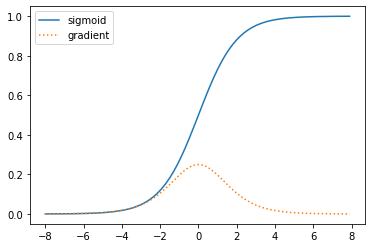

In [20]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach().numpy(), y.detach().numpy(), label = 'sigmoid')
plt.plot(x.detach().numpy(), x.grad.numpy() ,linestyle=':', label = 'gradient')
plt.legend()
plt.show()

可以看出，当sigmoid函数的输入很大或是很小时，它的梯度都是一个远远小于1的数，非常趋近于0。当反向传播通过许多层时，除非每一层的sigmoid函数的输入都恰好接近于零，否则整个乘积的梯度可能会消失。 当我们的网络有很多层时，除非我们很小心，否则在某一层可能就会切断梯度。 因此，现在大家更愿意选择更稳定的ReLU系列函数作为激活函数。

## 5.7.3 梯度爆炸

与之相反的则是梯度爆炸问题。梯度爆炸是指当梯度传递到深层时，由于参数的初始值或激活函数的形式，梯度变得非常大，从而导致训练难以收敛。为了更直观的看到这个问题，我们用代码生成了100个高斯随机矩阵，并将这些矩阵与一个矩阵相乘，这个矩阵相当于模型的初始参数矩阵。我们设置方差为1，看一下运行结果。

In [25]:
Mat = torch.normal(0, 1, size=(5,5))
print('初始参数矩阵',Mat)
for i in range(100):
    Mat = torch.mm(Mat, torch.normal(0, 1, size=(5, 5)))

print('计算后矩阵', Mat)

初始参数矩阵 tensor([[ 1.5515, -0.5073, -2.4602, -1.9177,  0.4678],
        [ 0.2328, -0.6902,  1.4514, -2.1545, -1.1679],
        [ 0.5522, -0.4998,  0.9615,  0.0644, -0.0136],
        [ 0.9784,  0.1601, -0.5344,  0.7700,  0.7958],
        [ 0.5089, -1.4568,  0.8654, -1.0948,  1.3430]])
计算后矩阵 tensor([[-1.0448e+29,  7.7966e+28,  9.1455e+28,  8.5349e+27, -2.6260e+29],
        [ 4.9579e+28, -3.6996e+28, -4.3397e+28, -4.0499e+27,  1.2461e+29],
        [ 3.3363e+28, -2.4895e+28, -2.9203e+28, -2.7253e+27,  8.3852e+28],
        [-3.9100e+28,  2.9176e+28,  3.4225e+28,  3.1940e+27, -9.8272e+28],
        [ 6.7301e+28, -5.0220e+28, -5.8909e+28, -5.4976e+27,  1.6915e+29]])


可以看到在经过100次乘法运算后，矩阵内的值发生了爆炸性增长，这就是梯度爆炸。这种情况其实是由于我们的参数初始化方法所导致的。

## 5.7.4 解决方法

解决梯度消失和梯度爆炸问题的方法很多，这里讲两种常见的方法，梯度裁剪和使用Relu函数。

**梯度裁剪（正则化）**

梯度裁剪主要是针对梯度爆炸提出。其思想也比较简单，训练时候设置一个阈值，梯度更新的时候，如果梯度超过阈值，那么就将梯度强制限制在该范围内，这时可以防止梯度爆炸。
权重正则化（weithts regularization)也可以解决梯度爆炸的问题，其思想就是我们常见的正则方式。
$$ Loss = (y-w^Tx)^2 + \alpha \left \| w \right \|^2 $$ 
α是正则化系数。如果发生梯度爆炸，$\left \| w \right \|$的平方会变得非常大，这样就可以一定程度避免梯度爆炸。

**采用Relu激活函数**

ReLU函数在AlexNet网络中最先提出。是一种常用的神经网络中的激活函数，它可以将输入信号的值转化为 0 或正数。ReLU 函数可以被表示为 $f(x)=max(0,x)$。由于relu激活函数的导数不是1就是0，因此不存在梯度消失问题，不同层之间的梯度基本保持一致。

而relu的缺点则是，负数部分恒为0，所以存在一定‘死区’，会导致一些神经元无法被激活，可以通过LeakyRelu等函数来改善死区的问题。

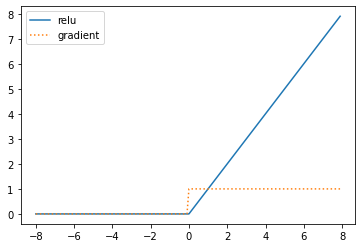

In [31]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
y.backward(torch.ones_like(x))

plt.plot(x.detach().numpy(), y.detach().numpy(), label = 'relu')
plt.plot(x.detach().numpy(), x.grad.numpy() ,linestyle=':', label = 'gradient')
plt.legend()
plt.show()

**其他方法**

决梯度消失和梯度爆炸的方法还有很多，比如下面这些：

1.使用 Batch Normalization 层，这样可以缩小梯度的范围，避免梯度爆炸的问题。

2.初始化权重参数，使用更加合理的初始化方法。

3.使用更加稳定的优化算法，如 Adam 优化器或 RMSprop 优化器，这些优化器可以自动调整学习率，使得训练更加稳定。

4.增加模型的宽度或使用残差连接，这样可以缓解深层网络中的梯度消失问题。

这些方法这里暂不做深入讲解，在今后的学习中大家会一点一点的接触到的。大家加油！

**梗直哥提示：梯度消失和梯度爆炸是深度学习中非常基础的问题，建议初学者在理解的基础上，亲自动手实践一下，相信你会记忆得更加深刻。如果你想了解更多内容，欢迎入群学习（加V: gengzhige99）**

[Next 5-8模型文件的读写](./5-8%20模型文件的读写.ipynb)